In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from __future__ import print_function
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy
import string
from spacy.matcher import Matcher
from spacy.tokens import Token
import pickle as pkl
from collections import Counter
import re
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
whitelist = {'cannot','neither','never',\
 'nevertheless',\
 'no',
 'nobody',
 'none',
 'noone',
 'nor',
 'not',
 'nothing','nowhere','unless'}
def change_stopwords(target_list):
    for word in target_list:
        tokenizer.vocab[word].is_stop = False


def tokenize3(sent):
    try:
        tokens = tokenizer(sent)
        result = []
        for token in tokens:
            if (token.is_punct) or (token.is_stop):
                pass
            elif token.lemma_ ==  '-PRON-':
                result.append(token.text.lower())
            else:
                result.append(token.lemma_)
        target_string = ' '.join(result) 
        return re.sub(r'[^\w\s]', '', target_string)
    except (KeyboardInterrupt, SystemExit):
        raise
    except TypeError: 
        pass
    
# remove negation from defaults stop words
change_stopwords(whitelist)

In [3]:
import pandas as pd
tweets1 = pd.read_csv("data/output_2015_06.csv",index_col=False)
tweets1.drop('Unnamed: 0',axis = 1, inplace = True)
texts = tweets1.loc[:, 'without_emoji_text']
print(tokenize3(texts[0]))

she say unenthused


In [4]:
len(tweets1)

5454385

In [118]:
# text1_tokenized = list(map(lambda x: tokenize3(x),texts[0:1000000]))
# text2_tokenized = list(map(lambda x: tokenize3(x),texts[1000000:2000000]))
# text3_tokenized = list(map(lambda x: tokenize3(x),texts[2000000:3000000]))
# text4_tokenized = list(map(lambda x: tokenize3(x),texts[3000000:4000000]))
# text5_tokenized = list(map(lambda x: tokenize3(x),texts[4000000:5000000]))
# text6_tokenized = list(map(lambda x: tokenize3(x),texts[5000000:]))
# text_tokenized = text1_tokenized + text2_tokenized + text3_tokenized + text4_tokenized + text5_tokenized + text6_tokenized
# text_tokenized = list(filter(None, text_tokenized))
# with open("201506.pickle", "wb") as output_file:
#     pkl.dump(text_tokenized, output_file)

10

In [5]:
with open("201506.pickle", "rb") as input_file:
    text_tokenized = pkl.load(input_file)

In [26]:
text_tokenized[0].split(" ")

['she', 'say', 'unenthused']

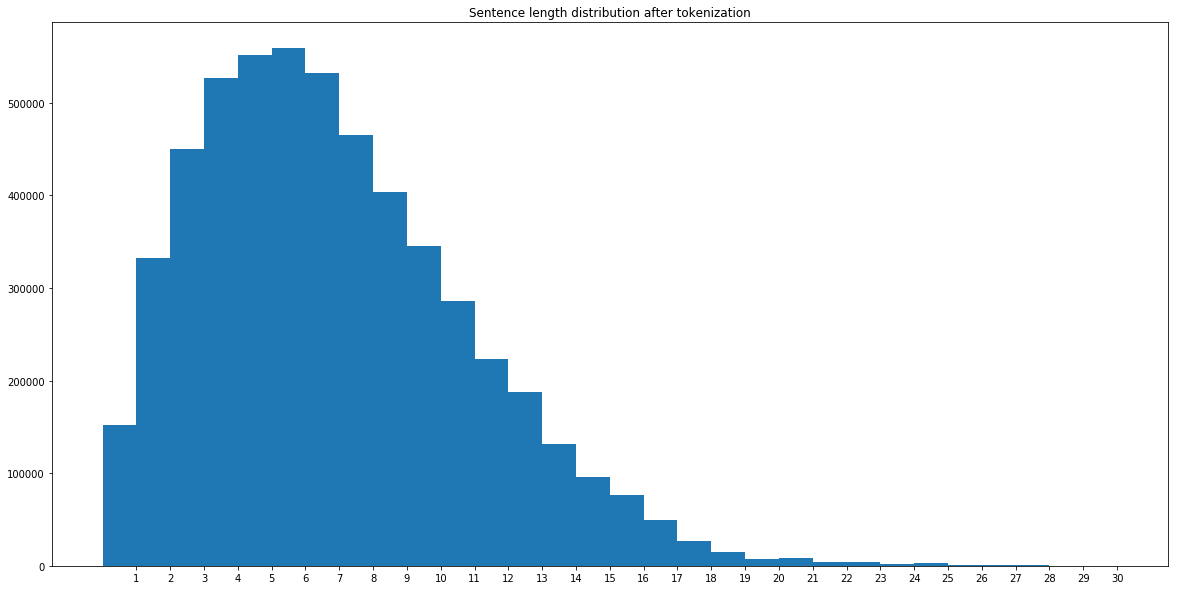

In [35]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
# labels, values = zip(*sorted(Counter([len(i.split(" ")) for i in text_tokenized]).items())[0:100])
labels, values = zip(*sorted(Counter([len(i.split(" ")) for i in text_tokenized]).items())[0:30])
indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.title('Sentence length distribution after tokenization')
plt.show()

# First try on LDA

In [234]:
n_topics = 20
n_top_words = 20
n_samples = len(text_tokenized)
n_features = 10000

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features)
t0 = time()
tf = tf_vectorizer.fit_transform(text_tokenized)

print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
   % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                             learning_method='online', learning_offset=50.,
                             random_state=0)
t0 = time()
lda.fit(tf)


with open("LDA_initialized.pickle", "wb") as output_file:
    pkl.dump(lda, output_file)
with open("LDA_initialized.pickle", "rb") as input_file:
    lda = pkl.load(input_file)
    
print("done in %0.3fs." % (time() - t0))
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

done in 6173.065s.

Topics in LDA model:
Topic #0:
think tonight ny right big lake school hot high at now win fl west dinner art red damn pic turn
Topic #1:
good amp love have look to need friend go run long amazing drive they road change co hear sunset tho
Topic #2:
be portland birthday girl not feel block say bad he wish she help would pa lose event crazy woman face
Topic #3:
be come ca san little check game make what airport video francisco international father hard finally dad lunch friday movie
Topic #4:
happy man see let police ave party kid se close up yesterday grill line excited rd dude gresham medical dr
Topic #5:
st or of old california los angeles enjoy end north ne mom car hollywood kill report your graffiti museum request
Topic #6:
be not great world start fuck baby sleep pretty eat hate how mean church saturday give celebrate month back hang
Topic #7:
today no mph wind rain humidity gt temperature fall 000 barometer food pressure rise weather 20 steady cloudy 12 00
Topic

# remove state stopwords and try lda

In [47]:
state_list = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming",
              "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

state_list = [i.lower() for i in state_list]

In [50]:
n_topics = 20
n_top_words = 20
n_samples = len(text_tokenized)
n_features = 10000

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features,stop_words = frozenset(state_list))
t0 = time()
tf = tf_vectorizer.fit_transform(text_tokenized)

pkl.dump(tf_vectorizer, open("tf_vectorizer_initialized_removeState.pickle", "wb"))
with open("tf_vectorizer_initialized_removeState.pickle", "rb") as input_file:
    tf_vectorizer = pkl.load(input_file)

print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
   % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                             learning_method='online', learning_offset=50.,
                             random_state=0)
t0 = time()
lda.fit(tf)


pkl.dump(lda, open("LDA_initialized_removeState.pickle", "wb"))
with open("LDA_initialized_removeState.pickle", "rb") as input_file:
    lda = pkl.load(input_file)
    
print("done in %0.3fs." % (time() - t0))
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=5441195 and n_features=10000...


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 3614.353s.

Topics in LDA model:
Topic #0:
the go just to be post photo of leave win music sleep mean lose saturday why kill your stadium country
Topic #1:
have we let thing what police long party drive hard road look up shop sunset finish ride die pizza hold
Topic #2:
love night think be say baby tell would dog crazy grill tho houston bed sister add sorry dr story maybe
Topic #3:
life mph today wind rain humidity stop gt temperature play fall real 000 barometer 10 francisco lot pressure rise rt
Topic #4:
happy be man girl see house 2015 club kid hate who yesterday excited rd ice season santa gresham valley cream
Topic #5:
new thank lol birthday feel york bad one los angeles rock county bring monday friday hollywood art show break face
Topic #6:
get today no this great year block fuck on food how work give first nigga job celebrate month back include
Topic #7:
be time game fun hot eat south picture help nothing there sure catch hang us welcome move festival spend after
Topic #8

# remove state stopwords and sentence length minimum is 4 and try lda

In [54]:
text_tokenized_len4 = [i for i in text_tokenized if len(i.split(" ")) > 3]
len(text_tokenized_len4)

4507104

In [55]:
n_topics = 20
n_top_words = 20
n_samples = len(text_tokenized_len4)
n_features = 10000

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features,stop_words = frozenset(state_list))
t0 = time()
tf = tf_vectorizer.fit_transform(text_tokenized_len4)

pkl.dump(tf_vectorizer, open("tf_vectorizer_initialized_removeState_length4.pickle", "wb"))
with open("tf_vectorizer_initialized_removeState_length4.pickle", "rb") as input_file:
    tf_vectorizer = pkl.load(input_file)

print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
   % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                             learning_method='online', learning_offset=50.,
                             random_state=0)
t0 = time()
lda.fit(tf)


pkl.dump(lda, open("LDA_initialized_removeState_length4.pickle", "wb"))
with open("LDA_initialized_removeState_length4.pickle", "rb") as input_file:
    lda = pkl.load(input_file)
    
print("done in %0.3fs." % (time() - t0))
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=4507104 and n_features=10000...


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 3374.101s.

Topics in LDA model:
Topic #0:
no this block 2015 say old baby food chicago event turn accident festival 06 american hold boston dude austin 30
Topic #1:
love park look big place fire music hard friday perfect face enjoy sunset traffic country garden miami blvd delay nw
Topic #2:
home little come if try find ready for video head awesome finally because bring sweet woman yesterday care excited pick
Topic #3:
be like thank miss nice lot call they saturday stay hang wear super thunderstorm mind ur glad warning resort mad
Topic #4:
friend birthday feel summer center bar bad out wish heart here yeah buy special come dance medical pizza forget dallas
Topic #5:
not get be want will think house stop start live fuck talk boy walk cool but ass meet church nigga
Topic #6:
be know you not portland week that hot real hope team help would she yes pic job why our town
Topic #7:
have play day lake long at end north view rt road national lady last water rd pool gresham dr second
Top

# remove state stopwords and sentence length minimum is 4 topic 30 and try lda

In [56]:
n_topics = 30
n_top_words = 20
n_samples = len(text_tokenized_len4)
n_features = 10000

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features,stop_words = frozenset(state_list))
t0 = time()
tf = tf_vectorizer.fit_transform(text_tokenized_len4)

pkl.dump(tf_vectorizer, open("tf_vectorizer_initialized_removeState_length4_top30.pickle", "wb"))
with open("tf_vectorizer_initialized_removeState_length4_top30.pickle", "rb") as input_file:
    tf_vectorizer = pkl.load(input_file)

print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
   % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                             learning_method='online', learning_offset=50.,
                             random_state=0)
t0 = time()
lda.fit(tf)


pkl.dump(lda, open("LDA_initialized_removeState_length4_top30.pickle", "wb"))
with open("LDA_initialized_removeState_length4_top30.pickle", "rb") as input_file:
    lda = pkl.load(input_file)
    
print("done in %0.3fs." % (time() - t0))
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=4507104 and n_features=10000...


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 3803.501s.

Topics in LDA model:
Topic #0:
of morning on baby hollywood store station super 06 santa boston easy true send only fort more throw tree orlando
Topic #1:
not park girl miss start wait pm enjoy lose sure believe trip actually move thunderstorm miami hand lmao warning severe
Topic #2:
lol god los angeles monday stay ya care hill ball eye dude welcome half as hall golden rn vs top
Topic #3:
week boy lot help would hate saturday day face town phone square mind office well ago another 30 bout am
Topic #4:
school hot high free nice county chicago market museum sw after from philadelphia central experience orange service chill air lovely
Topic #5:
be not people little do shit guy when that cool but because yesterday who excited pool drop season remember plan
Topic #6:
no want friend birthday feel bad car event stadium special include visit forget dallas minute sit read cry reason till
Topic #7:
happy think year man day party kid follow red late yeah far creek fight always

# remove state stopwords and sentence length minimum is 4 topic 50 and try lda

In [57]:
n_topics = 50
n_top_words = 20
n_samples = len(text_tokenized_len4)
n_features = 10000

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features,stop_words = frozenset(state_list))
t0 = time()
tf = tf_vectorizer.fit_transform(text_tokenized_len4)

pkl.dump(tf_vectorizer, open("tf_vectorizer_initialized_removeState_length4_top50.pickle", "wb"))
with open("tf_vectorizer_initialized_removeState_length4_top50.pickle", "rb") as input_file:
    tf_vectorizer = pkl.load(input_file)

print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
   % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                             learning_method='online', learning_offset=50.,
                             random_state=0)
t0 = time()
lda.fit(tf)


pkl.dump(lda, open("LDA_initialized_removeState_length4_top50.pickle", "wb"))
with open("LDA_initialized_removeState_length4_top50.pickle", "rb") as input_file:
    lda = pkl.load(input_file)
    
print("done in %0.3fs." % (time() - t0))
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=4507104 and n_features=10000...


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 4923.741s.

Topics in LDA model:
Topic #0:
of police out road river nyc tuesday by disney more its orange 25 wit matter crew middle eb may sometimes
Topic #1:
no this girl say include dude warning severe forever literally tired future cuz saint wtf jam test tag practice fact
Topic #2:
week boy hair case sound fort fam daddy type til instead daily hr makeup grind commercial purchase bread 21st 300
Topic #3:
be help would damn town square hall fucking 1st af an brown series truck cheer goal continue stupid tryna wrap
Topic #4:
look wait bar weekend god follow class sunset austin begin john bless buyer official pull everybody track jesus forward location
Topic #5:
not good you point sweet movie there believe thunderstorm bout even falls anymore blast luck plus deserve hilton scene chase
Topic #6:
open street leave request 10 mean stay iphone yeah 15 clean eye vs top rest sidewalk intersection idk feeling android
Topic #7:
view nothing late grill rd houston july dr as avenue curren

# remove state stopwords and sentence length minimum is 4 topic 100 and try lda

In [58]:
n_topics = 100
n_top_words = 20
n_samples = len(text_tokenized_len4)
n_features = 10000

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features,stop_words = frozenset(state_list))
t0 = time()
tf = tf_vectorizer.fit_transform(text_tokenized_len4)

pkl.dump(tf_vectorizer, open("tf_vectorizer_initialized_removeState_length4_top100.pickle", "wb"))
with open("tf_vectorizer_initialized_removeState_length4_top100.pickle", "rb") as input_file:
    tf_vectorizer = pkl.load(input_file)

print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
   % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                             learning_method='online', learning_offset=50.,
                             random_state=0)
t0 = time()
lda.fit(tf)


pkl.dump(lda, open("LDA_initialized_removeState_length4_top100.pickle", "wb"))
with open("LDA_initialized_removeState_length4_top100.pickle", "rb") as input_file:
    lda = pkl.load(input_file)
    
print("done in %0.3fs." % (time() - t0))
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()


Fitting LDA models with tf features, n_samples=4507104 and n_features=10000...


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 8814.372s.

Topics in LDA model:
Topic #0:
beer white black sure woman your more tap coach conference 19 album scene fail huntington banana carnival filter headquarters pot
Topic #1:
park look big place dinner bro avenue buyer sports nap 500 sis picnic capitol awake reunion penn pregnant ann rehearsal
Topic #2:
amazing west coffee shop include selfie chill shirt bowl casa stout energy rid steak pacific vintage almost fabulous loud husband
Topic #3:
no this block say accident stadium mind delay literally tired future train practice contact football dumb rule welfare should shoulder
Topic #4:
ya half disney final child land 60 fix attention safe lemon cinemas any mid men sandy rap usually nose lab
Topic #5:
think state god follow university dance kick bless track jesus location part dry christ prayer excuse crack garage legacy athletic
Topic #6:
so thing but ass happen wake local gay build huge much sexy shake important basketball apparently random blessing jenner ruin
Topic #7:


In [64]:
lda.transform(tf_vectorizer.transform(['I like apple']))

array([[0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.33666667, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00333333, 0.00333333,
        0.00333333, 0.00333333, 0.00333333, 0.00

In [123]:
sample = ['nyc pizza severe cup everybody wednesday chocolate',"most people don't realize this, but you can eat organic, gluten free food"]
print("topic prob distribution：")
print(lda.transform(tf_vectorizer.transform(sample)))
print("topic rank:")
[i[::-1 ]for i in np.argsort(lda.transform(tf_vectorizer.transform(sample)))]

topic prob distribution：
[[1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-03 1.25000000e-03
  1.25000000e-03 1.25000000e-03 1.25000000e-0

[array([77, 99, 35, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 24, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 25, 23, 48, 22,  1,  2,  3,  4,  5,  6,
         7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 47, 49,
        98, 74, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
        92, 93, 94, 95, 96, 97, 75, 73, 50, 72, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,  0]),
 array([ 3, 22,  7, 76, 99,  9,  6, 18, 16, 66, 19, 13, 32, 33, 31, 36, 34,
        35, 38, 37, 29, 39, 40, 41, 42, 43, 44, 45, 46, 30, 23, 28, 27,  1,
         2,  4,  5,  8, 10, 11, 12, 14, 15, 17, 20, 21, 48, 24, 25, 26, 47,
        49, 98, 50, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
        91, 92, 93, 94, 95, 96, 97, 75, 74, 73, 60, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 61, 72, 62, 63, 64, 65, 67, 68, 69, 70, 71,  0])]